## 1. Settings
### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

### 2) Set hyperparameters

In [2]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 1

## 2. Data

### 1) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

### 2) Set DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 3. Model & Optimizer
### 1) Model

In [5]:
class Encoder(nn.Module):
    #encoding 시에는 CNN과 같이 Convolution layer를 써준다.
    #Encoder는 일반적인 CNN 모델과 같다.

    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16), #일괄 정규화. 성능과 안정성을 향상시킨다. 
                        #Gradient Vanishing / Gradient Exploding를 방지한다.
                        #https://shuuki4.wordpress.com/2016/01/13/batch-normalization-%EC%84%A4%EB%AA%85-%EB%B0%8F-%EA%B5%AC%ED%98%84/
                        nn.Conv2d(16,32,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32), 
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1) #size 변환
        return out
    
encoder = Encoder() #model 생성

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        #decoding에는 Conv의 역 연산을 하는 Convolution Transposed layer을 써준다.
        # ConvTranspose2d : (in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1), #2배로 늘어난다. #[batch, 256, 7, 7] -> [batch, 128, 14, 14]
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1), #채널이 줄어든다. #[batch, 128, 14, 14] -> [batch, 64, 14, 14]
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1), #채널이 줄어든다. #[batch, 64, 14, 14] -> [batch, 16, 14, 14]
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1), #2배로 늘어난다. #[batch, 16, 14, 14] -> [batch, 1, 28, 28]
                        #처음 encoding 전의 data size로 맞춰준다.
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7) #decoder의 input에 맞춰서 size 변환
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder() #model 생성

#여기서는 encoder, decoder를 따로 만들었지만, FC에서 했던 것 처럼 하나의 class에 모두 넣어도 된다.

### 2) Loss func & Optimizer

In [7]:
parameters = list(encoder.parameters())+ list(decoder.parameters())
#각 모델에서 업데이트할 변수들을 model.parameters()로 가져온다.
#encoder, decoder의 파라미터를 list로 묶어서 학습하도록 전달한다.
loss_func = nn.MSELoss() #Autoencoder에서 손실 함수는 주로 L1 이나 L2를 사용한다.
optimizer = torch.optim.Adam(parameters, lr=learning_rate) #최적화함수
#업데이트해야 할 모든 변수들을 넣어준다. 보통  model이 하나일 때는, model.parameters()로 하면 된다.
#나눠서 2번 해도 되지만 한 번에 하는 것이 편하다.
#손실에서 lr만큼 움직이고 업데이트 하던 것을 알아서 최적화해서 처리해 준다.

## 4. Train 

In [8]:
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl') #이전에 학습한 모델이 있다면 불러온다.
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(num_epoch): #num_epoch만큼 반복
    for j,[image,label] in enumerate(train_loader): #DataLoader에서 batch 만큼씩 가져온다.
        optimizer.zero_grad() #optimiser.step() 으로 업데이트된 그라디언트 값들을 초기화해 줘야 한다.
        
        output = encoder(image) #encoding #4.0부터는 Variable 없이 그냥 Tensor를 그대로 넣어도 된다.
        output = decoder(output) #decoding #4.0부터는 Variable 없이 그냥 Tensor를 그대로 넣어도 된다.
        loss = loss_func(output, image) #예측한 값과, 정답
        #Autoencoder는 Unsupervised Learning에 많이 쓰인다. Label(정답)이 따로 존재하지 않는다.
        #loss 계산은 encoding, decoding한 이후 나온 output 값과 encoder의 input 값을 비교해 얻을 수 있다(L1, L2 loss를 주로 사용).
        
        loss.backward() #역전파 해준다.
        optimizer.step() #변수 업데이트
        
    if j % 10 == 0:
        torch.save([encoder,decoder],'./model/conv_autoencoder.pkl') #모델을 저장한다.
        print(loss)


--------model not restored--------



## 5. Check with Train Image

torch.Size([100, 28, 28])


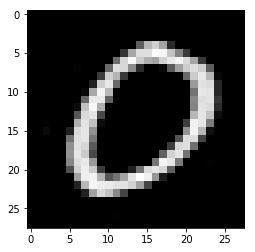

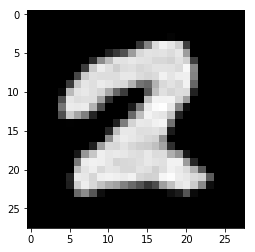

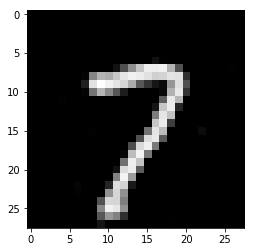

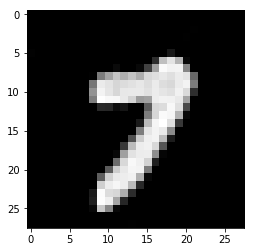

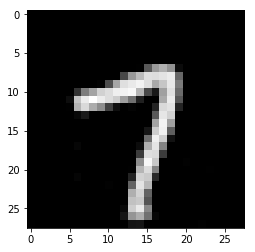

In [9]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    #plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    #plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()
    
# out_img = torch.squeeze(output)
# print(out_img.size()) #batch, width, height

# for i in range(out_img.size()[0]):
#     #plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
#     #plt.show()
#     plt.imshow(out_img[i].detach().numpy(),cmap='gray')
#     plt.show()